# Импортируем библиотеки

In [80]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split

import lightgbm as lgbm
import xgboost as xgb
import catboost

# Загружаем датасеты

In [81]:
# Загружаем данные

train_data = pd.read_csv('data/train_processed.csv')
valid_data = pd.read_csv('data/valid_processed.csv')

# Подготавливаем данные для обучения моделей

In [82]:
# Разделяем датасеты на выборки

# Чиним заголовки, иначе LightGBM ругается
train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
valid_data = valid_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Разделяем train датасет на таргет и признаки
X_train = train_data.drop(columns=['target'])  # Признаки
y_train = train_data['target']  # Таргет

# Разделяем valid датасет на таргет и признаки
X_valid = valid_data.drop(columns=['target']) # Признаки
y_valid = valid_data['target'] # Таргет

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Балансировка данных с помощью SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Функция вывода метрик модели

In [116]:
def print_metrics(model, model_name):
    
    # test выборка
    test_predictions = model.predict(X_test)
    test_probabilities = model.predict_proba(X_test)[:, 1]

    test_accuracy = accuracy_score(y_test, test_predictions)
    test_presicion = precision_score(y_test, test_predictions)
    test_recall = recall_score(y_test, test_predictions)
    test_f1score = f1_score(y_test, test_predictions)
    test_roc_auc = roc_auc_score(y_test, test_probabilities)

    # valid выборка
    valid_predictions = model.predict(X_valid)
    valid_probabilities = model.predict_proba(X_valid)[:, 1]

    valid_accuracy = accuracy_score(y_valid, valid_predictions)
    valid_presicion = precision_score(y_valid, valid_predictions)
    valid_recall = recall_score(y_valid, valid_predictions)
    valid_f1score = f1_score(y_valid, valid_predictions)
    valid_roc_auc = roc_auc_score(y_valid, valid_probabilities)

    submission_valid = pd.DataFrame({'client_id': valid_data.loc[X_valid.index, 'client_id'], 'score': valid_probabilities})
    submission_valid.to_csv(model_name + '_submission.csv', index=False)

    # Выводим метрики
    print(f"""\nТест на тестовой выборке
    Accuracy: {test_accuracy:.4f}
    Precision: {test_presicion:.4f}
    Recall: {test_recall:.4f}
    F1-Score: {test_f1score:.4f}
    ROC-AUC: {test_roc_auc:.4f}\n
    """)

    print(f"""Тест на валидационной выборке
    Accuracy: {valid_accuracy:.4f}
    Precision: {valid_presicion:.4f}
    Recall: {valid_recall:.4f}
    F1-Score: {valid_f1score:.4f}
    ROC-AUC: {valid_roc_auc:.4f}
    """)

    # ROC-кривая для test
    fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
    ROC_test = roc_auc_score(y_test, test_probabilities)

    # ROC-кривая для valid
    fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, valid_probabilities)
    ROC_valid = roc_auc_score(y_valid, valid_probabilities)

    plt.figure(figsize=(10, 6))

    # Вывод test
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {ROC_test:.2f}) on Test and ')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) on ' + model_name)
    plt.legend(loc="lower right")
    plt.grid(True)

    # Вывод valid
    plt.plot(fpr_valid, tpr_valid, color='red', lw=2, label=f'ROC curve (area = {ROC_valid:.2f}) on Valid')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) on ' + model_name)
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return valid_probabilities, 

# LightGBM

In [117]:
# Обучаем модель
lgbm_model = lgbm.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11211, number of negative: 11211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33658
[LightGBM] [Info] Number of data points in the train set: 22422, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()


Тест на тестовой выборке
    Accuracy: 0.9782
    Precision: 0.6515
    Recall: 0.5181
    F1-Score: 0.5772
    ROC-AUC: 0.9629

    
Тест на валидационной выборке
    Accuracy: 0.9805
    Precision: 0.2222
    Recall: 0.0303
    F1-Score: 0.0533
    ROC-AUC: 0.7464
    


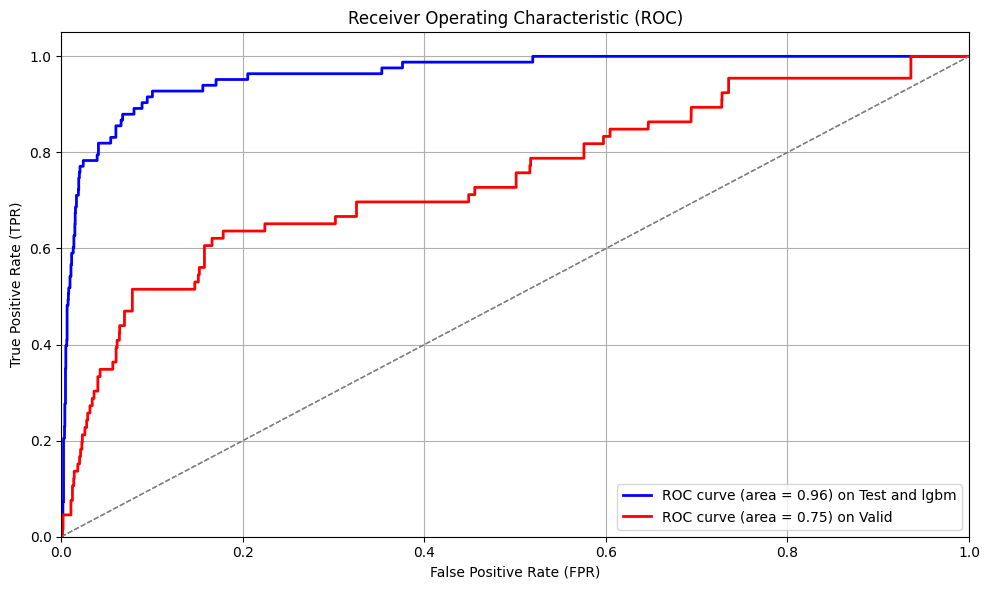

In [118]:
# Выводим метрики по LightGBM
lgbm_model_metric = print_metrics(lgbm_model, 'lgbm')

# XGBoost

In [119]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Тест на тестовой выборке
    Accuracy: 0.9848
    Precision: 0.7826
    Recall: 0.6506
    F1-Score: 0.7105
    ROC-AUC: 0.9709

    
Тест на валидационной выборке
    Accuracy: 0.9808
    Precision: 0.3571
    Recall: 0.0758
    F1-Score: 0.1250
    ROC-AUC: 0.7580
    


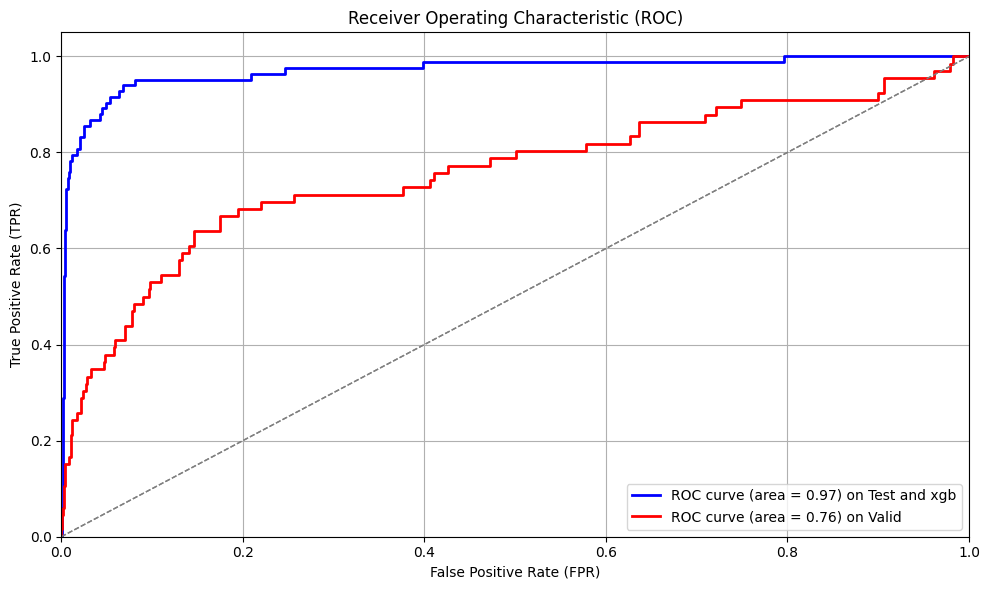

In [120]:
xgb_model_metric = print_metrics(xgb_model, 'xgb')

# CatBoost

In [121]:
catboost_model = catboost.CatBoostClassifier()
catboost_model.fit(X_train, y_train)

Learning rate set to 0.038875
0:	learn: 0.6632633	total: 23.3ms	remaining: 23.3s
1:	learn: 0.6278842	total: 44.6ms	remaining: 22.3s
2:	learn: 0.5986613	total: 64.7ms	remaining: 21.5s
3:	learn: 0.5753222	total: 85.7ms	remaining: 21.3s
4:	learn: 0.5503004	total: 107ms	remaining: 21.3s
5:	learn: 0.5339867	total: 127ms	remaining: 21s
6:	learn: 0.5167242	total: 148ms	remaining: 21s
7:	learn: 0.5032734	total: 169ms	remaining: 20.9s
8:	learn: 0.4864275	total: 190ms	remaining: 20.9s
9:	learn: 0.4707879	total: 211ms	remaining: 20.9s
10:	learn: 0.4551672	total: 232ms	remaining: 20.9s
11:	learn: 0.4411459	total: 254ms	remaining: 20.9s
12:	learn: 0.4301986	total: 273ms	remaining: 20.8s
13:	learn: 0.4219423	total: 295ms	remaining: 20.8s
14:	learn: 0.4088132	total: 317ms	remaining: 20.8s
15:	learn: 0.4023751	total: 337ms	remaining: 20.7s
16:	learn: 0.3897461	total: 357ms	remaining: 20.7s
17:	learn: 0.3812426	total: 379ms	remaining: 20.7s
18:	learn: 0.3721286	total: 399ms	remaining: 20.6s
19:	learn: 


Тест на тестовой выборке
    Accuracy: 0.9820
    Precision: 0.7460
    Recall: 0.5663
    F1-Score: 0.6438
    ROC-AUC: 0.9585

    
Тест на валидационной выборке
    Accuracy: 0.9808
    Precision: 0.1667
    Recall: 0.0152
    F1-Score: 0.0278
    ROC-AUC: 0.7410
    


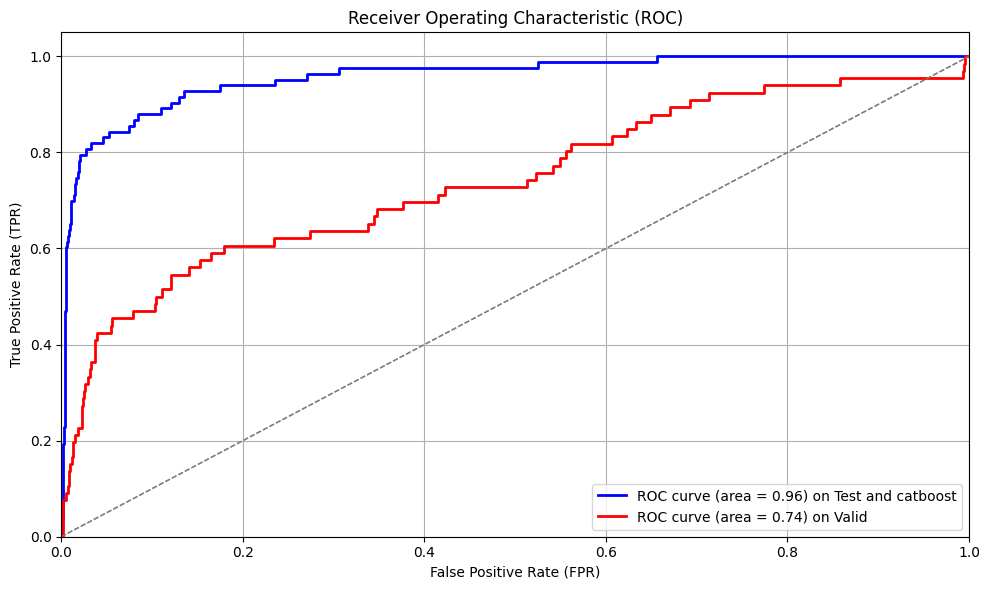

In [122]:
catboost_model_metric = print_metrics(catboost_model, 'catboost')

# Random Forest

In [123]:
random_forest_model = RandomForestClassifier(
    random_state=42
)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


Тест на тестовой выборке
    Accuracy: 0.9827
    Precision: 0.7797
    Recall: 0.5542
    F1-Score: 0.6479
    ROC-AUC: 0.9699

    
Тест на валидационной выборке
    Accuracy: 0.9827
    Precision: 0.6154
    Recall: 0.1212
    F1-Score: 0.2025
    ROC-AUC: 0.7733
    


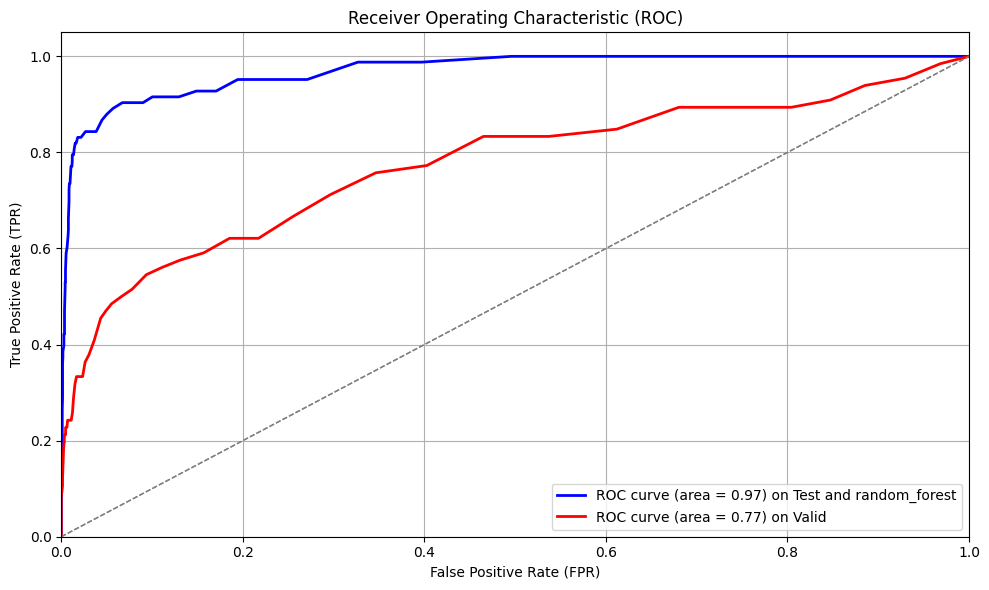

In [124]:
random_forest_model_model_metric = print_metrics(random_forest_model, 'random_forest')